In [45]:
from __future__ import division, print_function

import time
import datetime

import numpy as np

from astropy import units as u
from astropy import constants as cnst

from astropy.coordinates import SkyCoord, Distance
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astropy.table import Table
from astropy import modeling

from astroquery.irsa_dust import IrsaDust

import emceemr
from emceemr import priors
import rgbmcmr

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [105]:
def save_pub_figure(basename, figdir='figures', fig=None):
    import os
    if fig is None:
        fig = plt.gcf()
    plt.savefig(os.path.join(figdir, basename+'.pdf'))
    plt.savefig(os.path.join(figdir, basename+'.png'))
    
def reprocess_triangle_for_pub(fig, labelsize=18):
    for ax in fig.axes:
        for txt in (ax.title, ax.xaxis.label, ax.yaxis.label):
            #boost the sizes of the labels
            txt.set_fontsize(labelsize)
            
            #strip out newlines unless they are before '='s
            if '=' not in txt.get_text():
                txt.set_text(txt.get_text().replace('\n', ''))

# Pisc A

In [110]:
d = np.loadtxt('PiscA_dolphot/piscA')
wcs = WCS(fits.getheader('PiscA_dolphot/PiscA_F606W_build_drc.chip1.fits'))

#object is roughly here
x0 = 3650
y0 = 5400

#control area
xc = 3500
yc = 3000

sc0 = SkyCoord.from_pixel(x0, y0, wcs)
ebvmap = IrsaDust.get_images(sc0,2*u.degree, 'ebv')[0][0].data
ebv = ebvmap[ebvmap.shape[0]//2, ebvmap.shape[0]//2]
A606W = ebv*2.471 # from S & F 11
A814W = ebv*1.526 # from S & F 11
A606W, A814W

# only use good stars
ds = d[d[:, 10]<2]

m606 = ds[:,15] - A606W
m606e = ds[:,17]
m814 = ds[:,28] - A814W
m814e = ds[:,30]
dpx_dwarf = np.hypot(x0-ds[:,2],y0-ds[:,3])
dpx_control = np.hypot(xc-ds[:,2],yc-ds[:,3])

ce = np.hypot(m606e, m814e)
me = m814e
c = m606-m814
m = m814

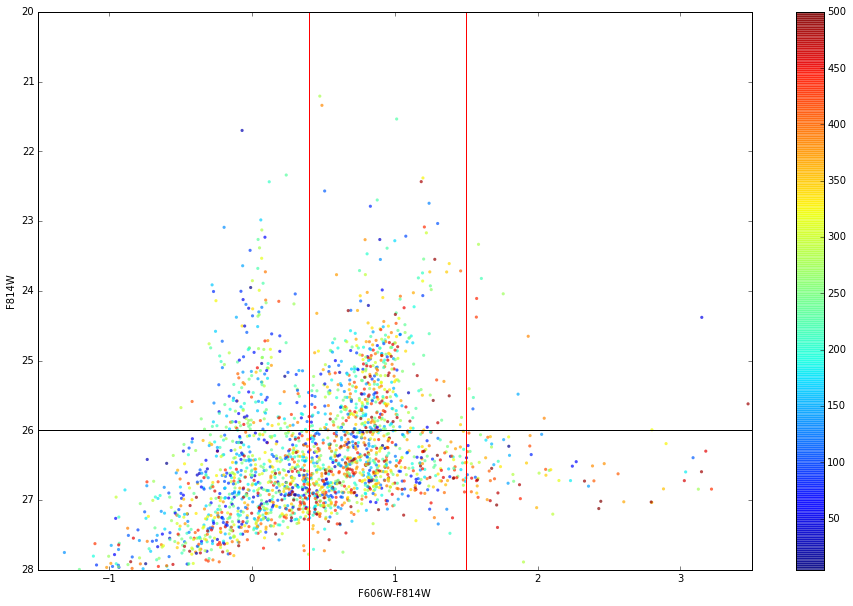

In [111]:
nearmsk = dpx_dwarf < 500

clims = (.4, 1.5)
mlim  = 26

plt.scatter(c[nearmsk], m[nearmsk], c=dpx_dwarf[nearmsk], s=10, edgecolor='none', alpha=.7)
plt.colorbar()
plt.xlim(-1.5, 3.5)
plt.ylim(28, 20)
plt.xlabel('F606W-F814W')
plt.ylabel('F814W')

for clim in clims:
    plt.axvline(clim, color='r')

plt.axhline(mlim, color='k')

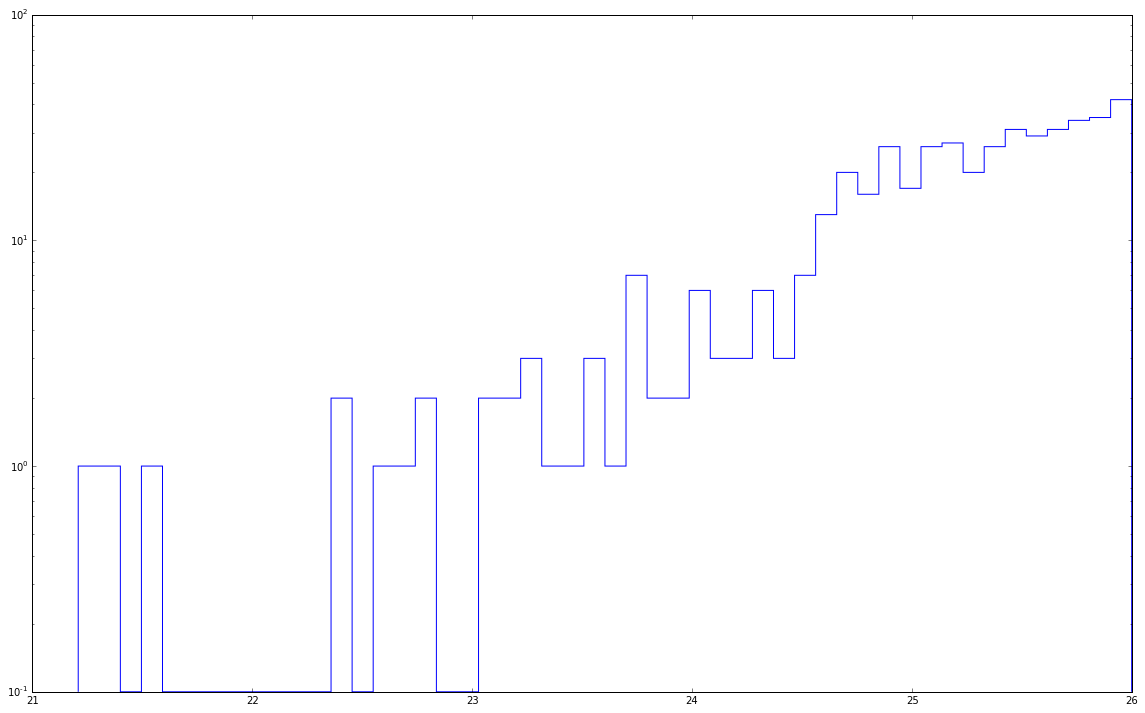

In [112]:
rgbmsk = nearmsk&(clims[0]<c)&(c<clims[1])&(m<mlim)&(m>20)
plt.hist(m[rgbmsk],bins=50, histtype='step',log=True)
plt.tight_layout()

Took 40.8532907963 sec
Acors:
tipmag: 41.0369717066
alphargb: 51.4519237776
alphaother: 41.8706574153
fracother: 44.816845563
Acceptance Fractions:
[ 0.6   ,  0.5952,  0.5974,  0.592 ,  0.5864,  0.5908,  0.594 ,  0.6058,
  0.5954,  0.6018,  0.5924,  0.5836,  0.5984,  0.5846,  0.5934,  0.5964]


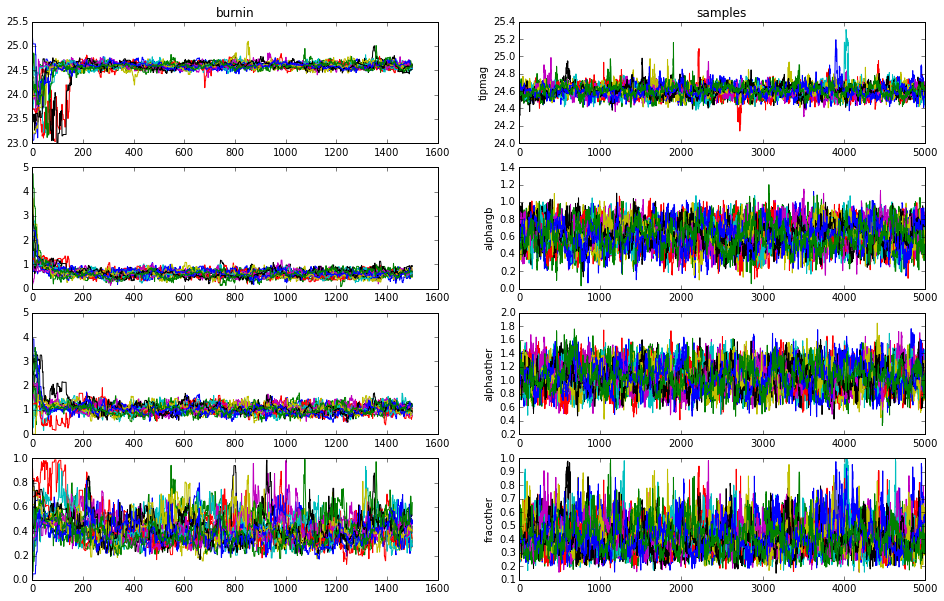

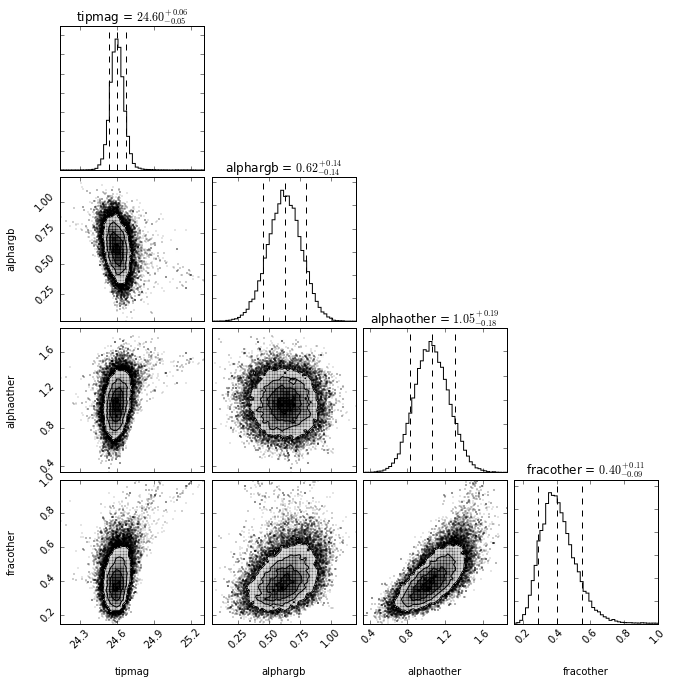

In [116]:
pris = dict(tipmag=priors.UniformPrior(23, 25.5),
            alphargb=priors.UniformPrior(0, 5), 
            alphaother=priors.UniformPrior(0, 5),
            fracother=priors.UniformPrior(0,1))

modA = rgbmcmr.RGBModel(m[rgbmsk], me[rgbmsk], priors=pris)

st = time.time()
samplerA = modA.initialize_and_sample(5000, burnin=1500)
et = time.time()
print('Took',et-st,'sec')

plt.figure()
emceemr.plot_chains(modA, samplerA)
plt.figure()
emceemr.triangle_plot(modA, samplerA, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(modA, samplerA))

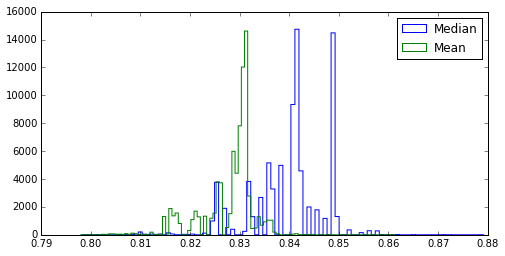

In [117]:
#for the color, we just find the median color of the top n stars in the RGB area
#ntip = 250
magsdown = 1
tipmagsA = emceemr.get_chain_by_name(modA, samplerA, 'tipmag')
crgb = c[rgbmsk].ravel()
mrgb = m[rgbmsk].ravel()
sorti = np.argsort(mrgb)
mrgb = mrgb[sorti]
crgb = crgb[sorti]
meds, means = [], []
for tm in tipmagsA.ravel():
    #topn = crgb[mrgb > tm][:ntip]
    topn = crgb[((tm+magsdown)>mrgb)&(mrgb > tm)]    
    meds.append(np.median(topn))
    means.append(np.mean(topn))

plt.figure(figsize=(8,4))
plt.hist(meds, bins=100, histtype='step', label='Median')
plt.hist(means, bins=100, histtype='step', label='Mean')
plt.legend()

tipcolorA = np.array(meds).reshape(tipmagsA.shape)

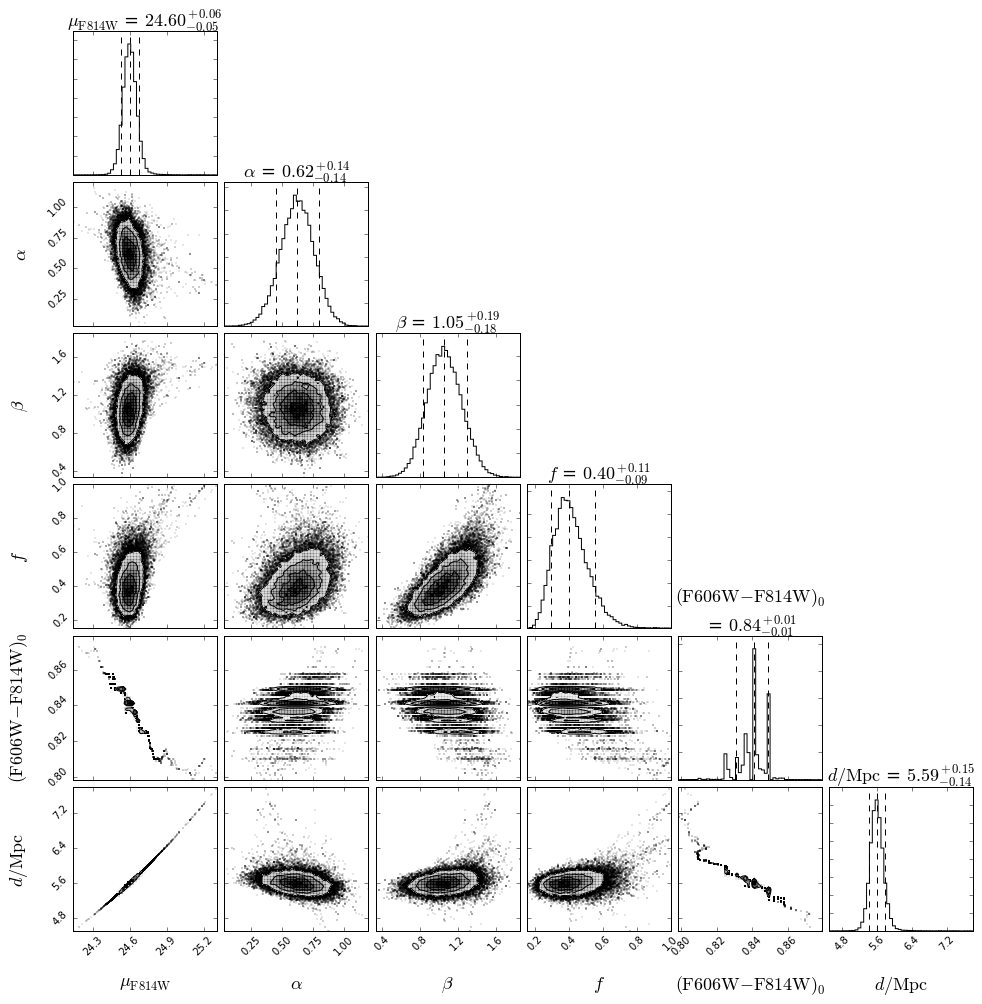

In [118]:
#now compute distance from Rizzi top of pg 13 for ACS F814W
rgb814_0 = -4.06+0.20*(tipcolorA-1.23) 
d_distrA = Distance(distmod=tipmagsA-rgb814_0)

emceemr.funcs.triangle_plot(modA, samplerA, quantiles=[.1, .5, .9], show_titles=True, 
                      chainstoadd=dict(tipcolor=tipcolorA.ravel(), 
                                       distance=d_distrA.Mpc.ravel()), 
                      relabel={'tipmag':r'$\mu_{\rm F814W}$',
                                     'alphargb':r'$\alpha$',
                                     'alphaother':r'$\beta$',
                                     'fracother':r'$f$',
                                     'tipcolor':r'$({\rm F606W-F814W})_0$'+'\n',
                                     'distance':r'$d/{\rm Mpc}$'},
                      verbose=False)

reprocess_triangle_for_pub(plt.gcf())
save_pub_figure('Pisc_A_corner')

# Pisc B

In [119]:
d = np.loadtxt('PiscB_dolphot/piscB')
wcs = WCS(fits.getheader('PiscB_dolphot/PiscB_F606W_drc.chip1.fits'))

#object is roughly here
x0 = 4250
y0 = 5900

#control area
xc = 3500
yc = 3000

sc0 = SkyCoord.from_pixel(x0, y0, wcs)
ebvmap = IrsaDust.get_images(sc0,2*u.degree, 'ebv')[0][0].data
ebv = ebvmap[ebvmap.shape[0]//2, ebvmap.shape[0]//2]
A606W = ebv*2.471 # from S & F 11
A814W = ebv*1.526 # from S & F 11
A606W, A814W

# only use good stars
ds = d[d[:, 10]<2]

m606 = ds[:,15] - A606W
m606e = ds[:,17]
m814 = ds[:,28] - A814W
m814e = ds[:,30]
dpx_dwarf = np.hypot(x0-ds[:,2],y0-ds[:,3])
dpx_control = np.hypot(xc-ds[:,2],yc-ds[:,3])

ce = np.hypot(m606e, m814e)
me = m814e
c = m606-m814
m = m814

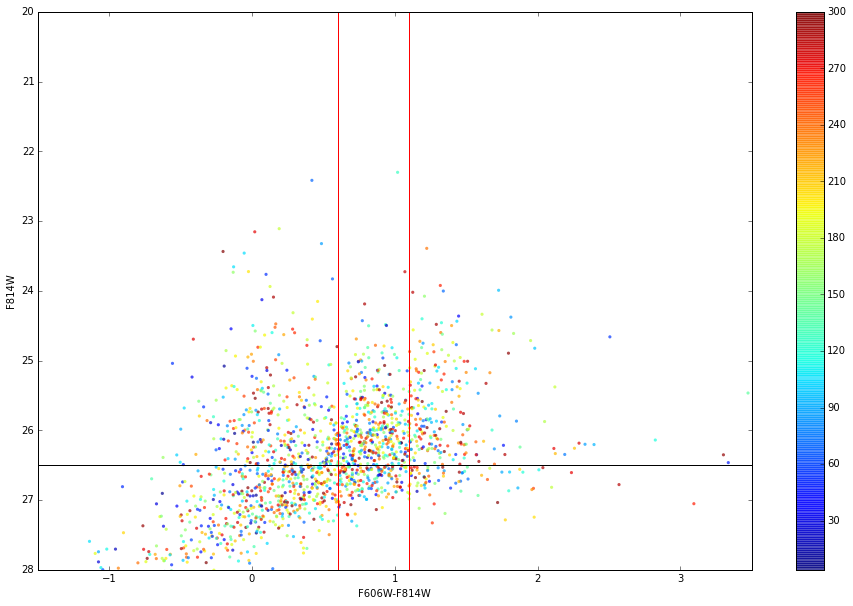

In [120]:
nearmsk = dpx_dwarf < 300

clims = (.6, 1.1)
mlim  = 26.5

plt.scatter(c[nearmsk], m[nearmsk], c=dpx_dwarf[nearmsk], s=10, edgecolor='none', alpha=.7)
plt.colorbar()
plt.xlim(-1.5, 3.5)
plt.ylim(28, 20)
plt.xlabel('F606W-F814W')
plt.ylabel('F814W')

for clim in clims:
    plt.axvline(clim, color='r')

plt.axhline(mlim, color='k')

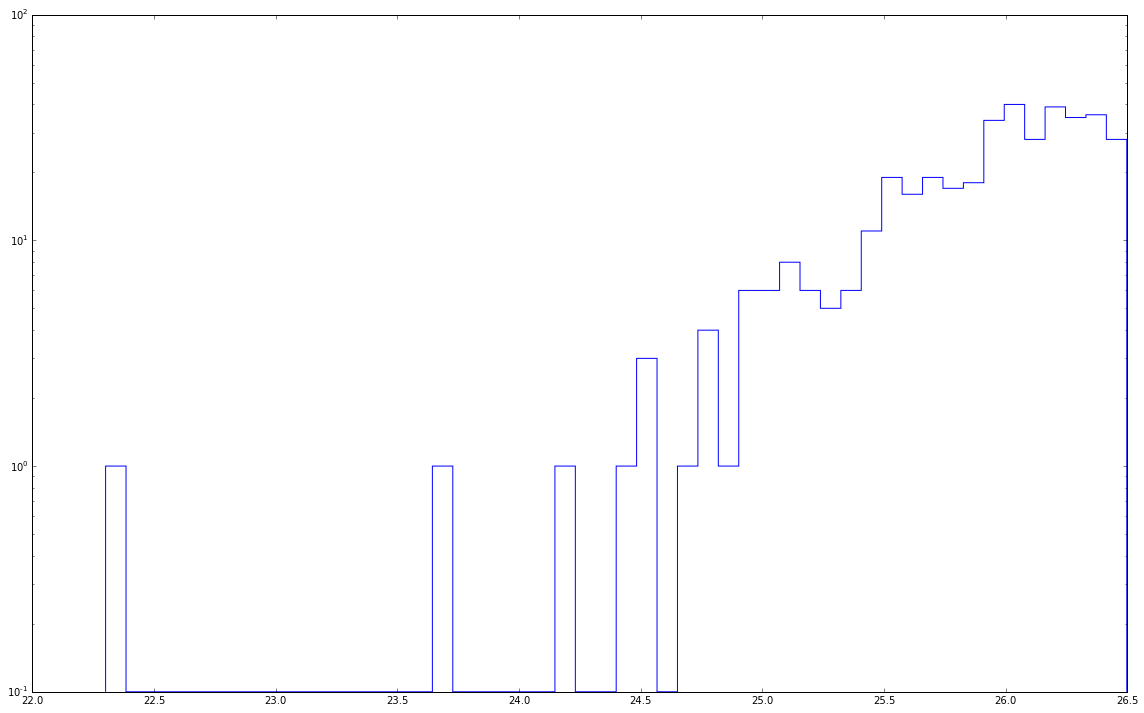

In [121]:
rgbmsk = nearmsk&(clims[0]<c)&(c<clims[1])&(m<mlim)&(m>20)
plt.hist(m[rgbmsk],bins=50, histtype='step',log=True)
plt.tight_layout()

Took 33.803331852 sec
Acors:
tipmag: 53.223415002
alphargb: 47.154932508
alphaother: 50.0769193294
fracother: 53.75600051
Acceptance Fractions:
[ 0.5208,  0.5344,  0.5316,  0.5314,  0.5236,  0.538 ,  0.5516,  0.5314,
  0.5212,  0.501 ,  0.5374,  0.5162,  0.5068,  0.515 ,  0.5218,  0.5022]


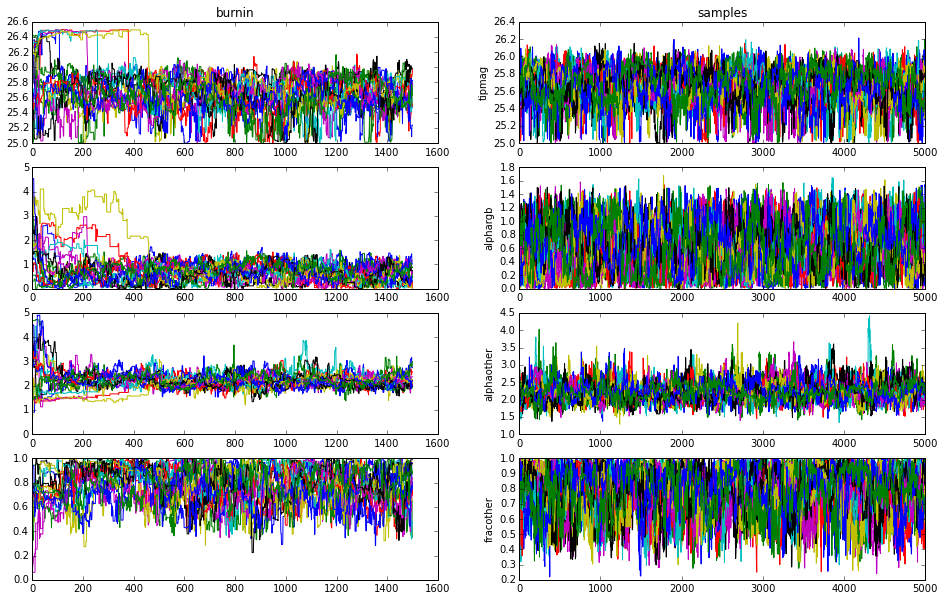

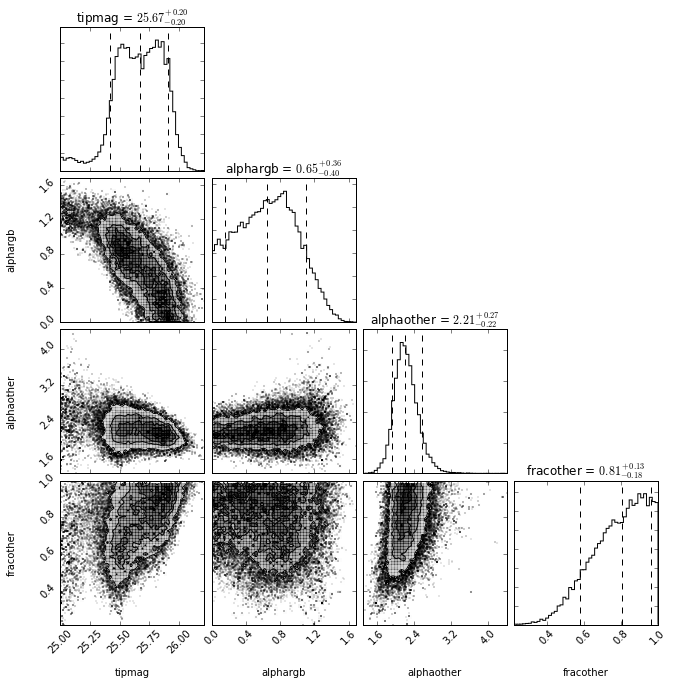

In [123]:
prisB = dict(tipmag=priors.UniformPrior(25, 26.5),
            #alphargb=priors.UniformPrior(0.2, 2.2),
             alphargb=priors.UniformPrior(0., 5),
             alphaother=priors.UniformPrior(0, 5),
             fracother=priors.UniformPrior(0,1))

modB = rgbmcmr.RGBModel(m[rgbmsk], me[rgbmsk], priors=prisB)

st = time.time()
samplerB = modB.initialize_and_sample(5000, burnin=1500)
et = time.time()
print('Took',et-st,'sec')

plt.figure()
emceemr.plot_chains(modB, samplerB)
plt.figure()
emceemr.triangle_plot(modB, samplerB, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(modB, samplerB))

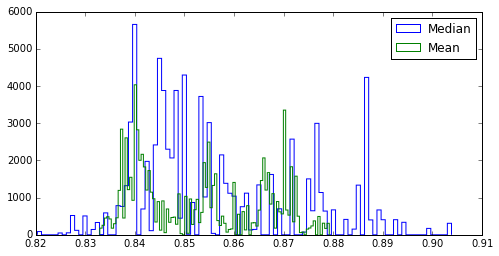

In [124]:
#for the color, we just find the median color of the top n stars in the RGB area
#ntip = 250
magsdown = 0.5
tipmagsB = emceemr.get_chain_by_name(modB, samplerB, 'tipmag')
crgb = c[rgbmsk].ravel()
mrgb = m[rgbmsk].ravel()
sorti = np.argsort(mrgb)
mrgb = mrgb[sorti]
crgb = crgb[sorti]
meds, means = [], []
for tm in tipmagsB.ravel():
    #topn = crgb[mrgb > tm][:ntip]
    topn = crgb[((tm+magsdown)>mrgb)&(mrgb > tm)]    
    meds.append(np.median(topn))
    means.append(np.mean(topn))

plt.figure(figsize=(8,4))
plt.hist(meds, bins=100, histtype='step', label='Median')
plt.hist(means, bins=100, histtype='step', label='Mean')
plt.legend()

tipcolorB = np.array(meds).reshape(tipmagsB.shape)

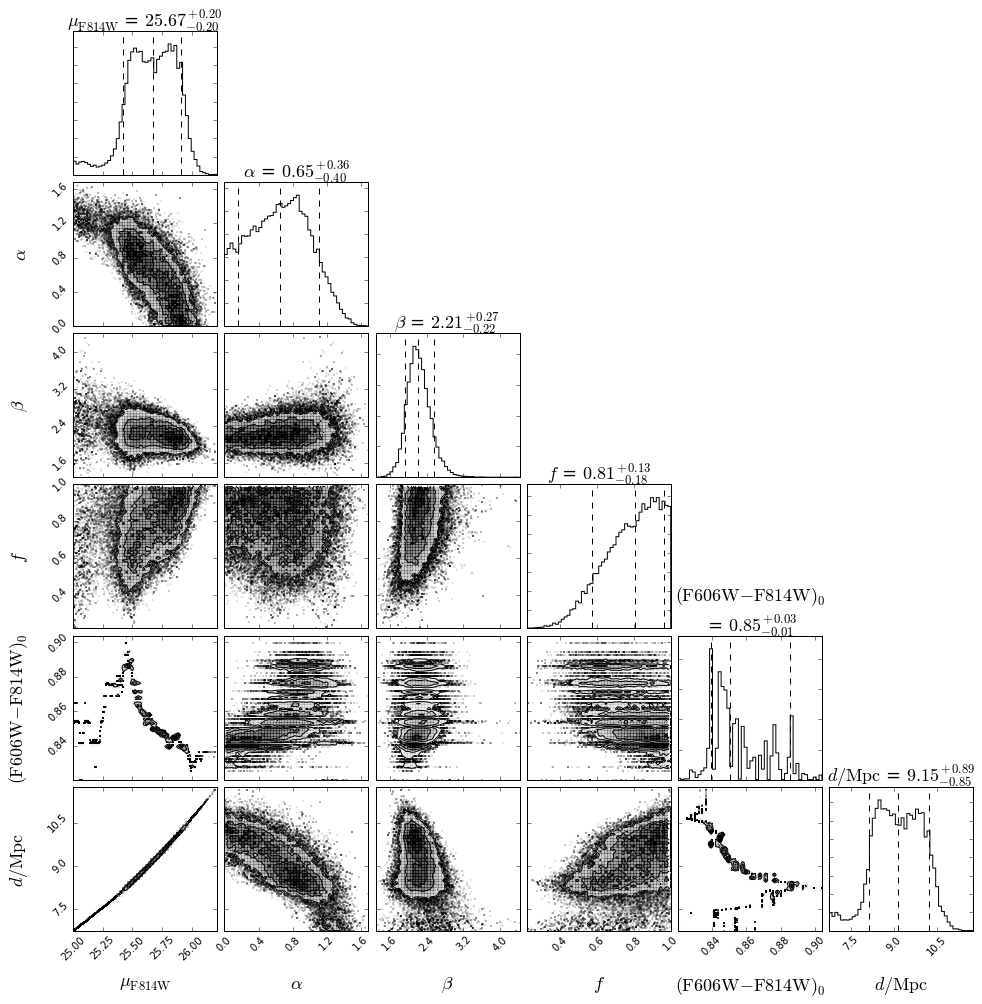

In [125]:
#now compute distance from Rizzi top of pg 13 for ACS F814W
rgb814_0 = -4.06+0.20*(tipcolorB-1.23) 
d_distrB = Distance(distmod=tipmagsB-rgb814_0)
emceemr.funcs.triangle_plot(modB, samplerB, quantiles=[.1, .5, .9], show_titles=True, 
                            chainstoadd=dict(tipcolor=tipcolorB.ravel(), distance=d_distrB.Mpc.ravel()), 
                            relabel={'tipmag':r'$\mu_{\rm F814W}$',
                                     'alphargb':r'$\alpha$',
                                     'alphaother':r'$\beta$',
                                     'fracother':r'$f$',
                                     'tipcolor':r'$({\rm F606W-F814W})_0$'+'\n',
                                     'distance':r'$d/{\rm Mpc}$'},
                            verbose=False)

reprocess_triangle_for_pub(plt.gcf())
save_pub_figure('Pisc_B_corner')

# Save Distance Results and Chains

In [126]:
datestamp = datetime.datetime.now().strftime('%Y_%m_%d')

In [127]:
np.savez('PiscAB_distances_{0}.npz'.format(datestamp), 
         piscA_dist_Mpc=d_distrA.Mpc, piscB_dist_Mpc=d_distrB.Mpc)

tosavedct = dict(modA=modA, modB=modB, chainsA=samplerA.chain, chainsB=samplerB.chain, param_names=modA.param_names)
np.savez('rgb_chains_{0}.npz'.format(datestamp), **tosavedct)

# Distance nicer histograms

Optimization terminated successfully.
         Current function value: -60185.581756
         Iterations: 18
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: -25879.918804
         Iterations: 17
         Function evaluations: 48


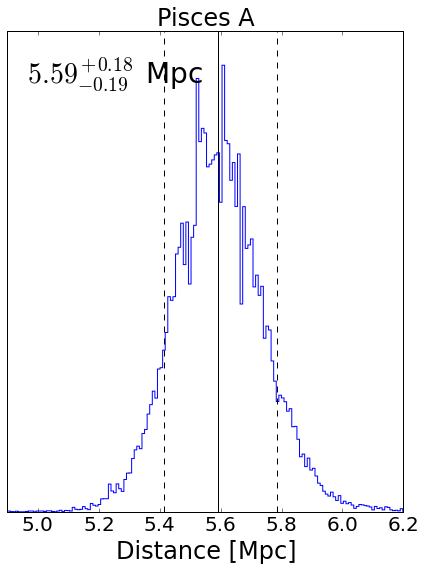

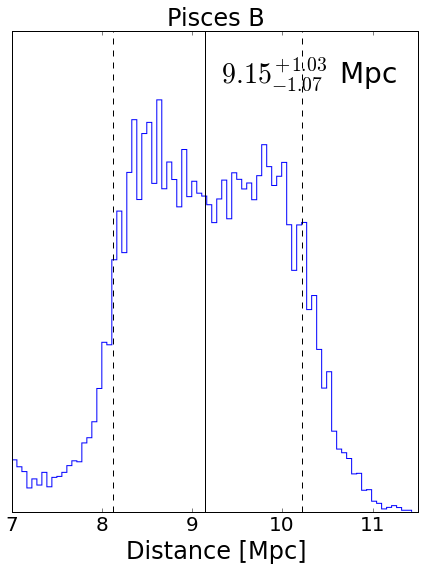

In [128]:
from astroML import plotting

def dist_hist(distr, xlims=None, bins='knuth', txtright=True):
    distr = distr.ravel().to(u.Mpc).value

    plotting.hist(distr, bins=bins, histtype='step', range=xlims)
    
    p10, p50, p90 = np.percentile(distr, [10, 50, 90])
    plt.axvline(p50, color='k')
    plt.axvline(p10, color='k', ls='dashed')
    plt.axvline(p90, color='k', ls='dashed')
    
    statsstr = r'${0:.2f}^<+{1:.2f}>_<{2:.2f}>$ Mpc'.format(p50,p50-p10,p50-p90).replace('<','{').replace('>','}')
    
    xtxt = 0.95 if txtright else 0.05
    ha = 'right' if txtright else 'left'
    plt.text(xtxt,0.95, statsstr, transform=plt.gca().transAxes, fontsize=28, ha=ha,va='top')
    
    if xlims is not None:
        plt.xlim(*xlims)
    plt.xlabel('Distance [Mpc]',fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks([])
    
    
plt.figure(figsize=(6,8))
dist_hist(d_distrA, (4.9,6.2), 'knuth',txtright=False)
plt.title('Pisces A', fontsize=24)
plt.tight_layout()
save_pub_figure('PiscA_dist')

plt.figure(figsize=(6,8))
dist_hist(d_distrB, (7,11.5), 'knuth')
plt.xticks([7,8,9,10,11])
plt.title('Pisces B', fontsize=24)
plt.tight_layout()
save_pub_figure('PiscB_dist')

In [129]:
#to allow "run all" and stop at the right place
1/0

ZeroDivisionError: division by zero

# Radial gradient checks

In [ ]:
bluebox = [-.4,.2,26,21.5]
redbox = [.5,1.2,26,24]

nearmsk = dpx_dwarf < 500

plt.scatter(c[nearmsk], m[nearmsk], s=10, edgecolor='none')
bluerect = plt.Rectangle((bluebox[0],bluebox[2]),bluebox[1]-bluebox[0],bluebox[3]-bluebox[2], facecolor='none', edgecolor='blue')
redrect = plt.Rectangle((redbox[0],redbox[2]),redbox[1]-redbox[0],redbox[3]-redbox[2], facecolor='none', edgecolor='red')
plt.gca().add_patch(bluerect)
plt.gca().add_patch(redrect)

plt.xlim(-1, 2)
plt.ylim(27, 20)

In [ ]:
bluemsk = (bluebox[0]<c)&(c<bluebox[1])&(bluebox[3]<m)&(m<bluebox[2])
redmsk = (redbox[0]<c)&(c<redbox[1])&(redbox[3]<m)&(m<redbox[2])
np.sum(bluemsk), np.sum(redmsk)

In [ ]:
plotting.hist(dpx_dwarf[bluemsk], bins=30, normed=True, color='b', histtype='step', range=(0,500))
plotting.hist(dpx_dwarf[redmsk], bins=30, normed=True, color='r', histtype='step', range=(0,500))
plt.tight_layout()

In [ ]:
for c, px1, px2 in zip(cs, px[:-1], px[1:])
    nearmsk = dpx_dwarf < 500
    plt.scatter(c[nearmsk], m[nearmsk], s=10, edgecolor='none')
plt.xlim(-1, 2)
plt.ylim(27, 20)

# ANGST comparisons

In [ ]:
d=fits.getdata('/Users/erik/astrodata/ANGST/hlsp_angst_hst_acs-wfc_9771-kk230_f606w-f814w_v1_gst.fits')

In [ ]:
c = d['MAG1_ACS']-d['MAG2_ACS']
m = d['MAG2_ACS']
plt.scatter(c, m, s=5, edgecolor='none',alpha=.5)
plt.xlim(-1,2)
plt.ylim(27,20)